In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
proj_dir = Path.cwd().parent.parent
path_label_dir = proj_dir / "data/processed/labels/labels_complete_for_viz"
path_label_dir

PosixPath('/home/tim/Documents/arxiv-code-search/data/processed/labels/labels_complete_for_viz')

In [3]:
def summarize_final_label_file(file_path, sample_size, publisher_name):

    # get file_name from file_path
    file_name = file_path.stem

    if file_name.endswith(".csv"):
        df = pd.read_csv(file_path, parse_dates=['update_date'])
    else:
        df = pd.read_excel(file_path, parse_dates=['update_date'], 
                            engine='odf',)
        df = df[["id", "pattern", "token_count", "update_date", "label", "para"]]
    
    # group id and aggregate by max label
    dfr = df.groupby(["id"]).agg({"label": "max"}).reset_index()

    # replace any NaN in "label" column with 0
    dfr.label.fillna(0, inplace=True)

    # the number of articles may have been more than what is contained in the file (because no keywords may have been found)
    sample_size_df = len(dfr)

    df_label_count = dfr.groupby('label').count().reset_index().astype(int)
    df_label_count = df_label_count.iloc[:,:2]
    df_label_count.columns = ['label', 'count']

    # the difference between sample_size and sample_size_df is the number of articles that had no keywords in the search
    df_label_count.loc[0, 'count'] += sample_size - sample_size_df

    missing_category = set(range(4)).difference(df_label_count.label.unique())

    for category in missing_category:
        df_label_count.loc[len(df_label_count)] = [category, 0]

    df_label_count_all = df_label_count.copy()

    def label_name(x):
        if x == 0:
            return "Data and Code Not\nPublicly Available"
        elif x == 1:
            return "Only Data\nPublicly Available"
        elif x == 2:
            return "Only Code\nPublicly Available"
        elif x == 3:
            return "Both Data and Code\nPublicly Available"
        else:
            return "Data and Code\nNot Available"

    df_label_count_all['label_name'] = df_label_count_all.label.apply(label_name)
    df_label_count_all['percentage'] = df_label_count_all['count'] / df_label_count_all['count'].sum() * 100
    df_label_count_all = df_label_count_all[['label_name', 'label', 'count', 'percentage']].sort_values(by='label')
    df_label_count_all['publisher'] = publisher_name
    df_label_count_all['sample_size'] = sample_size

    # create new column called "label_name" where the value is 0 if the label is 0, 1 if the label is greater than 0
    df_label_count['label_name'] = df_label_count.label.apply(
        lambda x: "Data and Code Not Available" if x == 0 else "Data or Code Publicly Available"
        )
    df_label_count['label'] = df_label_count.label.apply(
        lambda x: 0 if x == 0 else 1
        )
    df_label_count = df_label_count.groupby(["label_name", "label"]).agg({"count": "sum"}).reset_index()
    df_label_count['percentage'] = df_label_count['count'] / df_label_count['count'].sum() * 100
    df_label_count['publisher'] = publisher_name
    df_label_count['sample_size'] = sample_size

    return df_label_count, df_label_count_all

In [197]:
file_name = "labels_phm_97_0-150.ods"
df, df_all = summarize_final_label_file(path_label_dir / file_name, sample_size=150, publisher_name="PHM Conf.")
df_all

,label_name,label,count,percentage,publisher,sample_size
0,Data and Code Not\nPublicly Available,0,119,79.333333,PHM Conf.,150
1,Only Data\nPublicly Available,1,26,17.333333,PHM Conf.,150
2,Only Code\nPublicly Available,2,4,2.666667,PHM Conf.,150
3,Both Data and Code\nPublicly Available,3,1,0.666667,PHM Conf.,150


In [198]:
df

,label_name,label,count,percentage,publisher,sample_size
0,Data and Code Not Available,0,119,79.333333,PHM Conf.,150
1,Data or Code Publicly Available,1,31,20.666667,PHM Conf.,150


In [97]:
file_name = "labels_energies_98_0-150.ods"
df, df_all = summarize_final_label_file(path_label_dir / file_name, sample_size=124, publisher_name="Energies")
df

,label_name,count,percentage,publisher,sample_size
0,Data and Code Not Available,117,94.354839,Energies,124
1,Data or Code Publicly Available,7,5.645161,Energies,124


In [98]:
file_name = "labels_mssp_99_0-100.ods"
df, df_all = summarize_final_label_file(path_label_dir / file_name, sample_size=100, publisher_name="MSSP")
df

,label_name,count,percentage,publisher,sample_size
0,Data and Code Not Available,92,92.0,MSSP,100
1,Data or Code Publicly Available,8,8.0,MSSP,100


In [99]:
file_name = "labels_1.ods"
df, df_all = summarize_final_label_file(path_label_dir / file_name, sample_size=100, publisher_name="arxiv")
df

,label_name,count,percentage,publisher,sample_size
0,Data and Code Not Available,55,55.0,arxiv,100
1,Data or Code Publicly Available,45,45.0,arxiv,100


In [100]:
df_all

,label_name,label,count,percentage,publisher,sample_size
0,Data and Code Not Available,0,55,55.0,arxiv,100
1,Data Publicly Available,1,24,24.0,arxiv,100
2,Code Publicly Available,2,17,17.0,arxiv,100
3,Data and Code Publicly Available,3,4,4.0,arxiv,100


# Figures

In [4]:
# combine dataframes
file_names_list = ["labels_phm_97_0-150.ods", "labels_energies_98_0-150.ods", "labels_mssp_99_0-100.ods", "labels_1.ods"]
publisher_names_list = ["PHM Conf.", "Energies", "MSSP", "arxiv"]
sample_size_list = [150, 124, 100, 100]


df_all_list = []
df_list = []
for file_name, publisher, sample_size in zip(file_names_list, publisher_names_list, sample_size_list):
    df, df_all = summarize_final_label_file(path_label_dir / file_name, sample_size, publisher)
    df_list.append(df)
    df_all_list.append(df_all)

df_all = pd.concat(df_all_list)
df = pd.concat(df_list)

In [5]:
df_all

,label_name,label,count,percentage,publisher,sample_size
0,Data and Code Not\nPublicly Available,0,119,79.333333,PHM Conf.,150
1,Only Data\nPublicly Available,1,26,17.333333,PHM Conf.,150
2,Only Code\nPublicly Available,2,4,2.666667,PHM Conf.,150
3,Both Data and Code\nPublicly Available,3,1,0.666667,PHM Conf.,150
0,Data and Code Not\nPublicly Available,0,117,94.354839,Energies,124
1,Only Data\nPublicly Available,1,5,4.032258,Energies,124
2,Only Code\nPublicly Available,2,2,1.612903,Energies,124
3,Both Data and Code\nPublicly Available,3,0,0.000000,Energies,124
0,Data and Code Not\nPublicly Available,0,92,92.000000,MSSP,100
1,Only Data\nPublicly Available,1,7,7.000000,MSSP,100


In [6]:
df

,label_name,label,count,percentage,publisher,sample_size
0,Data and Code Not Available,0,119,79.333333,PHM Conf.,150
1,Data or Code Publicly Available,1,31,20.666667,PHM Conf.,150
0,Data and Code Not Available,0,117,94.354839,Energies,124
1,Data or Code Publicly Available,1,7,5.645161,Energies,124
0,Data and Code Not Available,0,92,92.000000,MSSP,100
1,Data or Code Publicly Available,1,8,8.000000,MSSP,100
0,Data and Code Not Available,0,55,55.000000,arxiv,100
1,Data or Code Publicly Available,1,45,45.000000,arxiv,100


In [7]:
def plot_percent_articles_by_venue(df):
    df = df[df["label"] == 1].sort_values(by="percentage", ascending=False)

    title = "Percentage of articles (by publishing venue)\nwith data or code publicly available"

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,7),)

    sns.set(style="whitegrid", font="DejaVu Sans")
    pal = sns.color_palette('Greys_r')
    font_size = 14

    # define color palette
    custom_pal = []
    for publisher in df['publisher']: 
        if publisher == 'PHM Conf.':
            # this palette https://www.color-hex.com/color-palette/94510
            custom_pal.append('#bd0c0c')
        else:
            custom_pal.append(pal[2])

    ax = sns.barplot(x="percentage", y="publisher", data=df, palette=custom_pal,)

    for p in ax.patches:
        # help from https://stackoverflow.com/a/56780852/9214620
        space = df["percentage"].max()*0.04
        _x = p.get_x() + p.get_width() + float(space)
        _y = p.get_y() + p.get_height() / 1.93
        value = p.get_width()
        
        ax.text(_x, _y, f"{int(np.round(value))}%", ha="left", va="center", weight="normal", size=font_size,)

    ax.spines["bottom"].set_visible(True)
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.grid(alpha=0.7, linewidth=1, axis="x")
    ax.set_xticks([0])
    ax.set_xticklabels([])
    #     ax.text(-0.4, 1.06, title,
    #     verticalalignment='top', horizontalalignment='left',
    #     transform=ax.transAxes,
    #     color='black', fontsize=12)

    ax.set_title(title, fontsize=font_size, loc='left', pad=20, x=-0.25)
    ax.tick_params(axis='y', labelsize=font_size)
    plt.subplots_adjust(wspace=0.3)
    sns.despine(left=True, bottom=True)
    plt.savefig('article_percentage.pdf',dpi=300,bbox_inches = "tight")
    plt.show()

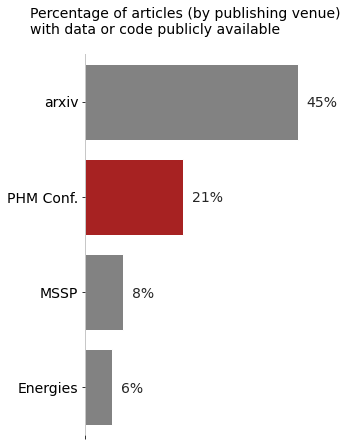

In [8]:
plot_percent_articles_by_venue(df)

In [9]:
def plot_individual_venue(df, publisher_name="PHM Conf."):
    df = df[df["publisher"] == publisher_name]

    title = "Percentage of articles (by publishing venue)\nwith data or code publicly available"

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,7),)

    sns.set(style="whitegrid", font="DejaVu Sans")
    pal = sns.color_palette('Greys_r')
    font_size = 14

    ax = sns.barplot(x="percentage", y="label_name", data=df, color='#bd0c0c',)

    for p in ax.patches:
        # help from https://stackoverflow.com/a/56780852/9214620
        space = df["percentage"].max()*0.04
        _x = p.get_x() + p.get_width() + float(space)
        _y = p.get_y() + p.get_height() / 1.93
        value = p.get_width()
        
        ax.text(_x, _y, f"{int(np.round(value))}%", ha="left", va="center", weight="normal", size=font_size,)

    ax.spines["bottom"].set_visible(True)
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.grid(alpha=0.7, linewidth=1, axis="x")
    ax.set_xticks([0])
    ax.set_xticklabels([])
    #     ax.text(-0.4, 1.06, title,
    #     verticalalignment='top', horizontalalignment='left',
    #     transform=ax.transAxes,
    #     color='black', fontsize=12)

    ax.set_title(title, fontsize=font_size, loc='left', pad=20, x=-0.25)
    ax.tick_params(axis='y', labelsize=font_size)
    plt.subplots_adjust(wspace=0.3)
    sns.despine(left=True, bottom=True)
    plt.savefig('article_percentage.pdf',dpi=300,bbox_inches = "tight")
    plt.show()

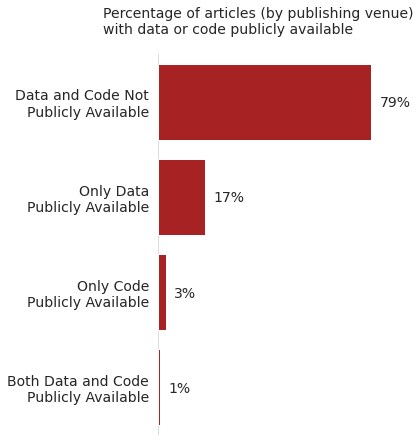

In [10]:
plot_individual_venue(df_all, publisher_name="PHM Conf.")

# Scratch

In [29]:
file_name = "labels_mssp_99_0-100.ods"
# file_name = "labels_energies_98_0-150.ods"

if file_name.endswith(".csv"):
    df = pd.read_csv(path_label_dir / file_name, parse_dates=['update_date'])
else:
    df = pd.read_excel(path_label_dir / file_name, parse_dates=['update_date'], 
                        engine='odf', names=["id", "pattern", "token_count", "update_date", "label", "para"],)
                        

df.head()

,id,pattern,token_count,update_date,label,para
0,10.1016_j.ymssp.2015.05.028,data,14,NaT,NaN,-T denotes the set of all measured data and f ...
1,10.1016_j.ymssp.2015.05.028,data,33,NaT,NaN,These new fx0; P0; Q ; Rg can be used to proce...
2,10.1016_j.ymssp.2015.05.028,data,59,NaT,NaN,An algorithm named Unscented Rauch–Tung–Strieb...
3,10.1016_j.ymssp.2015.05.028,data,88,NaT,NaN,"In this paper, the study is limited to the ana..."
4,10.1016_j.ymssp.2015.05.028,data,159,NaT,NaN,"Finally, the influence of the M4 bolts torque ..."


In [30]:
# group id and aggregate by max label
dfr = df.groupby(["id"]).agg({"label": "max"}).reset_index()

# replace any NaN in "label" column with 0
dfr.label.fillna(0, inplace=True)
print("Number of articles in df:", len(dfr))
dfr.head()

Number of articles in df: 85


,id,label
0,10.1016_j.ymssp.2015.05.028,0.0
1,10.1016_j.ymssp.2016.04.014,0.0
2,10.1016_j.ymssp.2016.04.028,1.0
3,10.1016_j.ymssp.2016.05.026,0.0
4,10.1016_j.ymssp.2016.07.049,0.0


In [31]:
# the number of articles may have been more than what is contained in the file (because no keywords may have been found)
n_articles = 100
n_articles_df = len(dfr)

df_label_count = dfr.groupby('label').count().reset_index().astype(int)
df_label_count = df_label_count.iloc[:,:2]
df_label_count.columns = ['label', 'count']

# the difference between n_articles and n_articles_df is the number of articles that had no keywords in the search
df_label_count.loc[0, 'count'] += n_articles - n_articles_df
df_label_count

,label,count
0,0,92
1,1,7
2,3,1


In [32]:
# create new column called "label_name" where the value is 0 if the label is 0, 1 if the label is greater than 0
df_label_count['label_name'] = df_label_count.label.apply(
    lambda x: "Data and Code Not Available" if x == 0 else "Data or Code Publicly Available"
    )
df_label_count = df_label_count.groupby(["label_name"]).agg({"count": "sum"}).reset_index()

# add percentage column of total
df_label_count['percentage'] = df_label_count['count'] / df_label_count['count'].sum() * 100
df_label_count

,label_name,count,percentage
0,Data and Code Not Available,92,92.0
1,Data or Code Publicly Available,8,8.0
